In [ ]:
import os
import cv2
import numpy as np
from astropy.io import fits
from tqdm import tqdm

# ========== 用户配置 ==========
input_dir = "/Users/zhiyu/Desktop/sir-sunspot"  # 确保路径无空格
output_dir = "/Users/zhiyu/Desktop/cropped"
video_name = "/Users/zhiyu/Desktop/sunspot_timelapse.avi"  # 改为.avi格式
crop_params = (300, 900, 300, 400)  # x, y, w, h
frame_rate = 5
# ============================

def load_fit_image(path):
    """读取.fit文件并归一化到8位"""
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        # 天文图像专用拉伸：先去除异常值再归一化
        vmin, vmax = np.percentile(data, [1, 99])  # 忽略1%的异常值
        data = np.clip(data, vmin, vmax)
        return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取.fit文件列表（严格匹配大小写）
image_files = sorted([f for f in os.listdir(input_dir) 
                     if f.lower().endswith(('.fit', '.fits'))])
assert len(image_files) > 0, f"未找到.fit文件，请检查目录: {input_dir}"

# AVI视频编码设置（天文图像推荐参数）
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # AVI兼容性最好的编码器
# 注意：AVI文件较大，但能完美保留天文数据细节
video_writer = cv2.VideoWriter(
    video_name, 
    fourcc,
    frame_rate, 
    (crop_params[2], crop_params[3]),  # 宽高
    isColor=False  # 灰度模式
)

# 处理流程
for filename in tqdm(image_files, desc="Processing FITS files"):
    img_path = os.path.join(input_dir, filename)
    
    try:
        # 读取和预处理
        img = load_fit_image(img_path)
        
        # 裁剪
        x, y, w, h = crop_params
        cropped = img[y:y+h, x:x+w]
        
        # 保存裁剪结果（可选）
        output_path = os.path.join(output_dir, f"cropped_{filename[:-4]}.png")
        cv2.imwrite(output_path, cropped)
        
        # 写入AVI视频（自动处理为8位）
        video_writer.write(cropped)
    except Exception as e:
        print(f"处理失败: {filename} - {str(e)}")

video_writer.release()
print(f"AVI视频生成完成: {video_name}")
print(f"文件大小: {os.path.getsize(video_name)/1024/1024:.2f} MB")

Processing FITS files:   2%|▍                    | 1/53 [00:01<01:23,  1.61s/it]

In [53]:
import os
import cv2
import numpy as np
from astropy.io import fits
from tqdm import tqdm

# ========== 用户配置 ==========
input_dir = "/Users/zhiyu/Desktop/sir-sunspot"  # 确保无末尾空格
output_dir = "/Users/zhiyu/Desktop/cropped"
video_name = "/Users/zhiyu/Desktop/sunspot_timelapse.mp4"
crop_params = (200, 300, 700, 800)  # x, y, w, h
frame_rate = 5
# ============================

def load_fit_image(path):
    """专用读取.fit/.fits文件"""
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        # 归一化到0-255范围（保留科学数据）
        return cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 获取.fit文件列表
image_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith('.fit')])
assert len(image_files) > 0, "未找到.fit文件"

# 视频写入器
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(
    video_name, fourcc, frame_rate, 
    (crop_params[2], crop_params[3]),  # 宽高
    isColor=False  # 灰度模式
)

# 处理流程
for filename in tqdm(image_files, desc="Processing .fit files"):
    img_path = os.path.join(input_dir, filename)
    
    try:
        # 读取.fit文件
        img = load_fit_image(img_path)
        
        # 裁剪
        x, y, w, h = crop_params
        cropped = img[y:y+h, x:x+w]
        
        # 保存裁剪结果（可选）
        output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}.png")
        cv2.imwrite(output_path, cropped)
        
        # 写入视频
        video_writer.write(cropped)
    except Exception as e:
        print(f"处理失败: {filename} - {str(e)}")

video_writer.release()
print(f"视频生成完成: {video_name}")

Processing .fit files: 100%|████████████████████| 53/53 [00:03<00:00, 17.13it/s]

视频生成完成: /Users/zhiyu/Desktop/sunspot_timelapse.mp4


In [69]:
import xarray as xr
import matplotlib.pyplot as plt

# 设置文件路径 (替换为实际路径)
file_path = "/Users/zhiyu/Desktop/dn_euvs-l2-avg1m_g19_d20250507_v1-0-6.nc"

try:
    # 打开NetCDF文件
    ds = xr.open_dataset(file_path)
    
    # 1. 查看数据集信息
    print("="*50)
    print("数据集信息:")
    print("="*50)
    print(ds)
    
    # 2. 查看全局属性
    print("\n" + "="*50)
    print("全局属性:")
    print("="*50)
    for attr_name, attr_value in ds.attrs.items():
        print(f"{attr_name}: {attr_value}")
    
    # 3. 查看变量列表
    print("\n" + "="*50)
    print("数据变量:")
    print("="*50)
    for var_name in ds.data_vars:
        var = ds[var_name]
        print(f"{var_name}:")
        print(f"  维度: {var.dims}")
        print(f"  形状: {var.shape}")
        print(f"  属性: {var.attrs}")
        print("-"*40)
    
    # 4. 查看坐标变量 (时间、波长等)
    print("\n" + "="*50)
    print("坐标变量:")
    print("="*50)
    for coord_name in ds.coords:
        coord = ds.coords[coord_name]
        print(f"{coord_name}:")
        print(f"  值范围: {float(coord.min().values)} 到 {float(coord.max().values)}")
        print(f"  单位: {coord.attrs.get('units', '无')}")
        print(f"  描述: {coord.attrs.get('long_name', '无')}")
        print("-"*40)
    
    # 5. 提取并可视化数据 (示例)
    # 选择第一个时间点和所有波长的辐照度数据
    if 'irradiance' in ds:
        # 假设时间坐标名为 'time'，波长坐标名为 'wavelength'
        time_coord = ds.time[0] if 'time' in ds.coords else ds.time[0]
        
        # 获取第一个时间点的数据
        sample_data = ds['irradiance'].isel(time=0)
        
        # 绘制光谱图
        plt.figure(figsize=(12, 6))
        sample_data.plot.line(x='wavelength', marker='o', markersize=3)
        
        plt.title(f"GOES-19 EUVS 光谱辐照度\n{time_coord.dt.strftime('%Y-%m-%d %H:%M:%S').item()}")
        plt.xlabel(f"波长 ({ds.wavelength.attrs.get('units', '未知单位')})")
        plt.ylabel(f"辐照度 ({ds['irradiance'].attrs.get('units', '未知单位')})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('goes_euvs_spectrum.png', dpi=150)
        plt.show()
    
    # 6. 时间序列分析 (示例)
    if 'time' in ds.coords and 'irradiance' in ds:
        # 选择特定波长 (例如 30.4 nm)
        wavelength = 30.4
        closest_wl = ds.wavelength.sel(wavelength=wavelength, method="nearest")
        
        # 提取该波长的时间序列
        time_series = ds['irradiance'].sel(wavelength=closest_wl)
        
        # 绘制时间序列
        plt.figure(figsize=(12, 6))
        time_series.plot.line(marker='o', markersize=3)
        
        plt.title(f"GOES-19 EUVS {float(closest_wl):.1f} nm 辐照度时间序列")
        plt.xlabel("时间")
        plt.ylabel(f"辐照度 ({ds['irradiance'].attrs.get('units', '未知单位')})")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('goes_euvs_timeseries.png', dpi=150)
        plt.show()
    
    # 7. 关闭数据集
    ds.close()

except FileNotFoundError:
    print(f"错误: 文件未找到 - {file_path}")
    print("请检查文件路径是否正确，文件是否存在于指定位置")
    
except Exception as e:
    print(f"处理文件时出错: {str(e)}")
    print("可能原因: 文件损坏、格式不兼容或权限问题")

数据集信息:
<xarray.Dataset> Size: 376kB
Dimensions:                    (time: 1440, lines: 7, bounds: 2,
                                wavelength_bin: 23)
Coordinates:
  * time                       (time) datetime64[ns] 12kB 2025-05-07 ... 2025...
Dimensions without coordinates: lines, bounds, wavelength_bin
Data variables: (12/45)
    irr_256                    (time) float32 6kB ...
    irr_284                    (time) float32 6kB ...
    irr_304                    (time) float32 6kB ...
    irr_1175                   (time) float32 6kB ...
    irr_1216                   (time) float32 6kB ...
    irr_1335                   (time) float32 6kB ...
    ...                         ...
    irr_304_1nm                (time) float32 6kB ...
    irr_1216_1nm               (time) float32 6kB ...
    yaw_flip_flag              (time) float32 6kB ...
    model_wavelength_bounds    (wavelength_bin, bounds) float32 184B ...
    model_irradiance_spectrum  (time, wavelength_bin) float32 132kB ...


In [73]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# 设置文件路径
file_path = "/Users/zhiyu/Desktop/dn_euvs-l2-avg1m_g19_d20250507_v1-0-6.nc"

try:
    # 打开NetCDF文件
    ds = xr.open_dataset(file_path)
    
    # 1. 查看数据集信息
    print("="*50)
    print("数据集信息:")
    print("="*50)
    print(ds)
    
    # 2. 查看全局属性
    print("\n" + "="*50)
    print("全局属性:")
    print("="*50)
    for attr_name, attr_value in ds.attrs.items():
        print(f"{attr_name}: {attr_value}")
    
    # 3. 处理时间坐标 - 转换为可读格式
    print("\n" + "="*50)
    print("时间坐标转换:")
    print("="*50)
    
    # 获取时间坐标数据
    time_var = ds['time']
    
    # 根据描述确定时间参考点
    ref_date = np.datetime64('2000-01-01T00:00:00')
    
    # 将数值时间戳转换为datetime64 (纳秒级精度)
    if time_var.dtype != np.dtype('datetime64[ns]'):
        # 如果时间不是datetime格式，进行转换
        time_ns = time_var.values.astype('timedelta64[ns]') + ref_date
        ds['time'] = time_ns
        print("时间坐标已转换为datetime64格式")
    
    # 创建日期时间索引
    time_index = pd.DatetimeIndex(ds.time.values)
    
    # 打印转换后的时间信息
    print(f"时间起点: {time_index[0]}")
    print(f"时间终点: {time_index[-1]}")
    print(f"时间间隔: {pd.to_timedelta(np.diff(time_index).min())}")
    print(f"时间点数量: {len(time_index)}")
    
    # 4. 查看其他坐标变量
    print("\n" + "="*50)
    print("其他坐标变量:")
    print("="*50)
    for coord_name in ds.coords:
        if coord_name == 'time': continue  # 跳过已处理的时间
        coord = ds.coords[coord_name]
        print(f"{coord_name}:")
        print(f"  值范围: {float(coord.min().values)} 到 {float(coord.max().values)}")
        print(f"  单位: {coord.attrs.get('units', '无')}")
        print(f"  描述: {coord.attrs.get('long_name', '无')}")
        if len(coord) < 10:  # 如果数量少，打印所有值
            print(f"  所有值: {coord.values}")
        else:  # 否则打印首尾值
            print(f"  首5值: {coord.values[:5]}")
            print(f"  尾5值: {coord.values[-5:]}")
        print("-"*40)
    
    # 5. 查看数据变量
    print("\n" + "="*50)
    print("数据变量:")
    print("="*50)
    for var_name in ds.data_vars:
        var = ds[var_name]
        print(f"{var_name}:")
        print(f"  维度: {var.dims}")
        print(f"  形状: {var.shape}")
        print(f"  单位: {var.attrs.get('units', '无')}")
        print(f"  描述: {var.attrs.get('long_name', '无')}")
        print("-"*40)
    
    # 6. 可视化数据 - 时间序列示例
    if 'irradiance' in ds:
        # 选择特定波长 (例如 30.4 nm)
        wavelength = 30.4
        closest_wl_idx = np.abs(ds.wavelength.values - wavelength).argmin()
        closest_wl = ds.wavelength.values[closest_wl_idx]
        
        # 提取该波长的辐照度时间序列
        time_series = ds['irradiance'].isel(wavelength=closest_wl_idx)
        
        # 创建图表
        plt.figure(figsize=(14, 7))
        plt.plot(time_index, time_series.values, 'b-', linewidth=1.5)
        
        # 设置时间格式
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))
        
        plt.title(f"GOES-19 EUVS {closest_wl:.1f} nm 辐照度时间序列\n{time_index[0].date()}", fontsize=14)
        plt.xlabel("UTC时间", fontsize=12)
        plt.ylabel(f"辐照度 ({ds['irradiance'].attrs.get('units', '未知单位')})", fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        # 保存并显示图像
        plt.savefig(f'goes_euvs_{closest_wl:.1f}nm_timeseries.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # 7. 可视化数据 - 光谱图示例
    if 'irradiance' in ds and 'wavelength' in ds.coords:
        # 选择特定时间 (例如正午)
        noon_time = np.datetime64(f'{time_index[0].date()}T12:00:00')
        time_idx = np.abs(time_index - noon_time).argmin()
        selected_time = time_index[time_idx]
        
        # 获取该时间点的光谱
        spectrum = ds['irradiance'].isel(time=time_idx)
        
        # 创建图表
        plt.figure(figsize=(14, 7))
        plt.plot(ds.wavelength.values, spectrum.values, 'r-', linewidth=2, marker='o', markersize=5)
        
        plt.title(f"GOES-19 EUVS 光谱辐照度\n{selected_time.strftime('%Y-%m-%d %H:%M:%S')} UTC", fontsize=14)
        plt.xlabel(f"波长 ({ds.wavelength.attrs.get('units', '未知单位')})", fontsize=12)
        plt.ylabel(f"辐照度 ({ds['irradiance'].attrs.get('units', '未知单位')})", fontsize=12)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        
        # 保存并显示图像
        plt.savefig(f'goes_euvs_spectrum_{selected_time.strftime("%H%M")}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # 8. 关闭数据集
    ds.close()

except FileNotFoundError:
    print(f"错误: 文件未找到 - {file_path}")
    print("请检查文件路径是否正确，文件是否存在于指定位置")
    
except Exception as e:
    print(f"处理文件时出错: {str(e)}")
    import traceback
    traceback.print_exc()

数据集信息:
<xarray.Dataset> Size: 376kB
Dimensions:                    (time: 1440, lines: 7, bounds: 2,
                                wavelength_bin: 23)
Coordinates:
  * time                       (time) datetime64[ns] 12kB 2025-05-07 ... 2025...
Dimensions without coordinates: lines, bounds, wavelength_bin
Data variables: (12/45)
    irr_256                    (time) float32 6kB ...
    irr_284                    (time) float32 6kB ...
    irr_304                    (time) float32 6kB ...
    irr_1175                   (time) float32 6kB ...
    irr_1216                   (time) float32 6kB ...
    irr_1335                   (time) float32 6kB ...
    ...                         ...
    irr_304_1nm                (time) float32 6kB ...
    irr_1216_1nm               (time) float32 6kB ...
    yaw_flip_flag              (time) float32 6kB ...
    model_wavelength_bounds    (wavelength_bin, bounds) float32 184B ...
    model_irradiance_spectrum  (time, wavelength_bin) float32 132kB ...


找到 53 个FITS文件
警告: 未找到时间戳关键字 'TIME'，将使用帧序号作为时间轴
处理完成，共处理 53 帧
光度数据已保存至: fits_luminance_data.csv


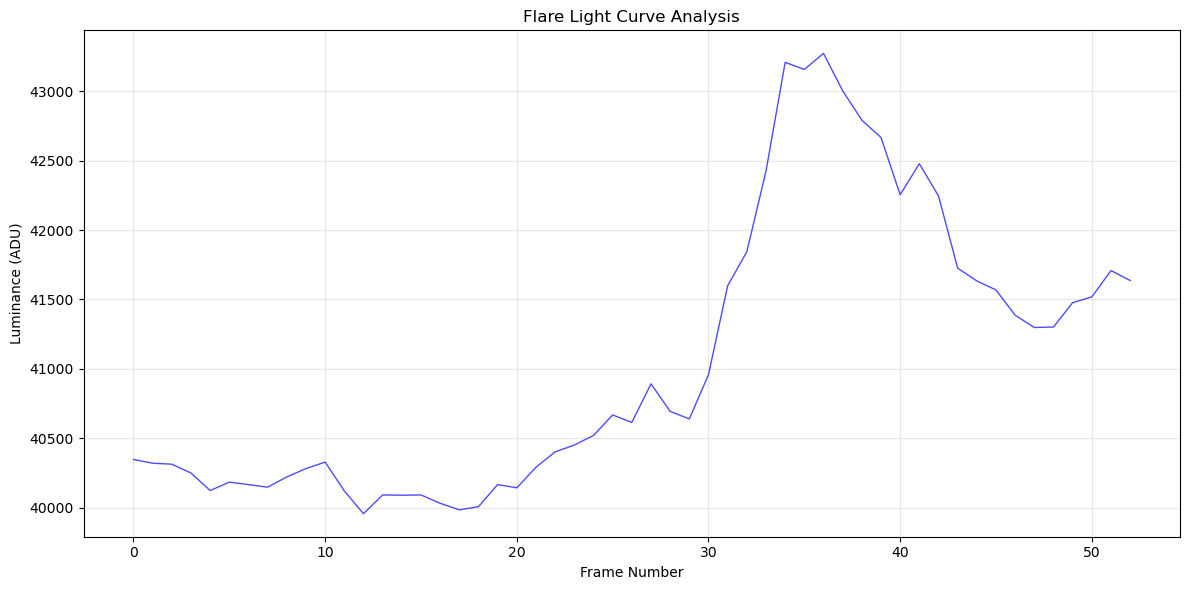

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
import os
from datetime import datetime, timedelta
import csv

def extract_fits_luminance(fits_files, output_csv=None, show_plot=True, time_keyword='DATE-OBS'):
    """
    提取FITS图像序列的总光度数据并生成光变曲线
    
    参数:
    fits_files: FITS文件路径列表或包含FITS文件的目录路径
    output_csv: 可选，保存光度数据的CSV文件路径
    show_plot: 是否显示光变曲线图
    time_keyword: FITS头中用于时间戳的关键字(默认为'DATE-OBS')
    """
    # 处理输入文件列表
    if isinstance(fits_files, str):
        if os.path.isdir(fits_files):
            file_list = sorted(glob.glob(os.path.join(fits_files, '*.fit')))
        else:
            file_list = sorted(glob.glob(fits_files))
    elif isinstance(fits_files, list):
        file_list = sorted(fits_files)
    else:
        raise ValueError("输入必须是文件列表、目录路径或文件模式")
    
    if not file_list:
        raise FileNotFoundError("未找到FITS文件")
    
    print(f"找到 {len(file_list)} 个FITS文件")
    
    # 存储光度数据和帧时间戳
    luminance_values = []
    timestamps = []
    time_format = None
    ref_time = None
    
    for i, file_path in enumerate(file_list):
        try:
            # 读取FITS文件
            with fits.open(file_path) as hdul:
                data = hdul[0].data
                header = hdul[0].header
                
                # 检查数据维度
                if data.ndim > 2:
                    # 尝试压缩多余维度
                    data = np.squeeze(data)
                    if data.ndim > 2:
                        raise ValueError(f"文件 {os.path.basename(file_path)} 有 {data.ndim} 维，请检查数据格式")
                
                # 计算整帧平均亮度
                frame_luminance = np.nanmean(data)
                luminance_values.append(frame_luminance)
                
                # 获取时间戳
                if time_keyword in header:
                    time_str = header[time_keyword]
                    
                    # 尝试自动检测时间格式
                    if time_format is None:
                        if 'T' in time_str:
                            time_format = '%Y-%m-%dT%H:%M:%S.%f'
                        elif ' ' in time_str:
                            time_format = '%Y-%m-%d %H:%M:%S.%f'
                        else:
                            time_format = '%H:%M:%S.%f'
                    
                    try:
                        # 处理不同精度的时间戳
                        if '.' in time_str:
                            dt = datetime.strptime(time_str, time_format)
                        else:
                            dt = datetime.strptime(time_str, time_format.split('.')[0])
                        
                        # 设置参考时间（第一个有效时间戳）
                        if ref_time is None:
                            ref_time = dt
                            timestamps.append(0.0)
                        else:
                            # 计算相对于第一帧的秒数
                            delta = dt - ref_time
                            timestamps.append(delta.total_seconds())
                    
                    except ValueError as e:
                        print(f"时间解析错误 ({time_str}): {e}")
                        # 回退到帧序号
                        timestamps.append(i)
                
                else:
                    # 如果没有时间戳关键字，使用帧序号
                    timestamps.append(i)
                    if i == 0:
                        print(f"警告: 未找到时间戳关键字 '{time_keyword}'，将使用帧序号作为时间轴")
            
            if (i + 1) % 100 == 0:
                print(f"已处理 {i+1}/{len(file_list)} 帧...")
        
        except Exception as e:
            print(f"处理文件 {file_path} 时出错: {str(e)}")
            # 跳过问题文件但保持索引一致
            luminance_values.append(np.nan)
            timestamps.append(i if not timestamps else timestamps[-1] + 1)
    
    print(f"处理完成，共处理 {len(file_list)} 帧")
    
    # 保存数据到CSV
    if output_csv:
        with open(output_csv, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['timestamp', 'luminance', 'filename'])
            for ts, lum, fname in zip(timestamps, luminance_values, file_list):
                writer.writerow([ts, lum, os.path.basename(fname)])
        print(f"光度数据已保存至: {output_csv}")
    
    # 绘制光变曲线
    if show_plot:
        plt.figure(figsize=(12, 6))
        plt.plot(timestamps, luminance_values, 'b-', linewidth=1, alpha=0.7)
        plt.title("Flare Light Curve Analysis")
        plt.xlabel("Time (seconds)" if ref_time else "Frame Number")
        plt.ylabel("Luminance (ADU)")
        plt.grid(alpha=0.3)
        
        # 标记耀斑事件（简单峰值检测）
        avg = np.nanmean(luminance_values)
        std = np.nanstd(luminance_values)
        peaks = np.where(np.array(luminance_values) > avg + 3*std)[0]
        if len(peaks) > 0:
            for p in peaks:
                plt.axvline(timestamps[p], color='r', linestyle='--', alpha=0.4)
            plt.text(0.02, 0.95, f"Detected {len(peaks)} potential flares", 
                     transform=plt.gca().transAxes, color='r')
        
        plt.tight_layout()
        plt.show()
    
    return timestamps, luminance_values, file_list

if __name__ == "__main__":
    # 输入可以是：目录路径、文件模式或文件列表
    fits_source = "/Users/zhiyu/Desktop/original-images./cropped_fits" # 替换为FITS文件目录
    # fits_source = "/path/to/files/flare_*.fits"  # 或使用文件模式
    
    output_file = "fits_luminance_data.csv"
    
    # 提取光度数据并绘图
    times, luminance, files = extract_fits_luminance(
        fits_source,
        output_csv=output_file,
        time_keyword='TIME'  # 根据具体FITS调整
    )
    
    # 后续分析可在此进行...